

### 1. Installation and Imports

First, we need to install the Yahoo Finance library and import our data science stack.

In [1]:
!pip install yfinance

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

---

### 2. Data Acquisition

We will pull the last 5 years of Bitcoin data.

In [2]:
# Download BTC data
df = yf.download('BTC-USD', start='2019-01-01', end='2024-01-01')

# We only need the 'Close' price for this simple model
data = df[['Close']]
print(data.head())

/tmp/ipython-input-2663849058.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start='2019-01-01', end='2024-01-01')
[*********************100%***********************]  1 of 1 completed

Price             Close
Ticker          BTC-USD
Date                   
2019-01-01  3843.520020
2019-01-02  3943.409424
2019-01-03  3836.741211
2019-01-04  3857.717529
2019-01-05  3845.194580


---

### 3. Data Preprocessing

LSTMs are very sensitive to the scale of the data. We use `MinMaxScaler` to squish the prices between 0 and 1.

In [3]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

# Splitting data into Training (80%) and Testing (20%)
training_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_size, :]

---

### 4. Sequence Generation

The model learns by looking at a "window" of the past (e.g., 60 days) to predict the next day.

In [4]:
def create_sequences(dataset, window_size=60):
    X, y = [], []
    for i in range(window_size, len(dataset)):
        X.append(dataset[i-window_size:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

window = 60
X_train, y_train = create_sequences(train_data, window)

# Reshape input to be [samples, time steps, features] which LSTM requires
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

---

### 5. Building the LSTM Model

We will stack two LSTM layers with **Dropout** layers to prevent overfitting.

In [5]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


44/44 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0425
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0038
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0031
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0026
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0032
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0030
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0026
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0023
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0020
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0021


---

### 6. Testing and Visualization

Now we prepare the test data, make predictions, and "un-scale" them back to actual dollar amounts.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


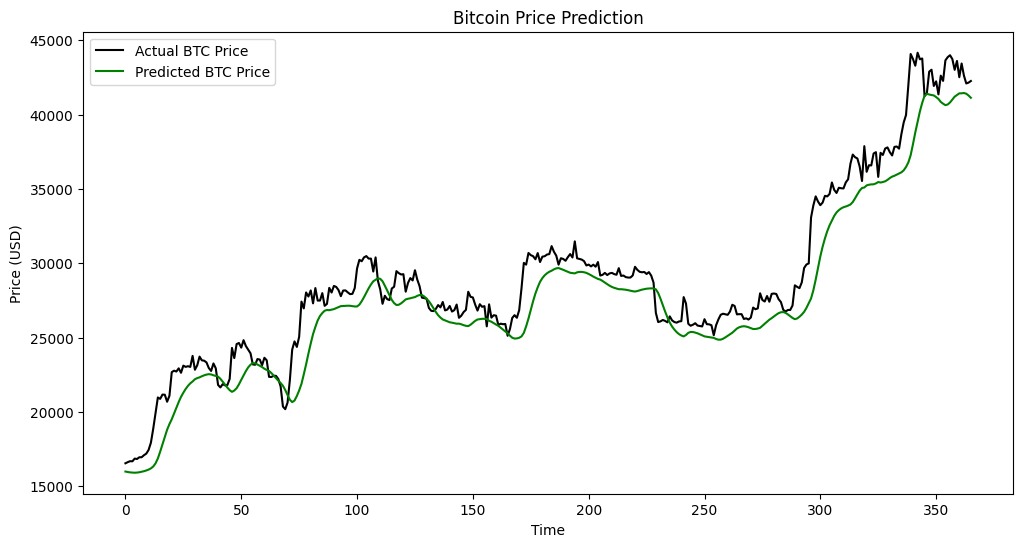

In [6]:
# Prepare test data
test_inputs = scaled_data[training_size - window:]
X_test, y_actual = create_sequences(test_inputs, window)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict and Inverse Transform
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_actual_prices = scaler.inverse_transform(y_actual.reshape(-1, 1))

# Plotting
plt.figure(figsize=(12,6))
plt.plot(y_actual_prices, color='black', label='Actual BTC Price')
plt.plot(predictions, color='green', label='Predicted BTC Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()